## This is the first attempt at testing a function for the aggregate view generation as first output of the analysis
### The function for this will be defined at the start and may be added to the utils afterwards

With INPUT: INCIDENT_CODE + DATE, the aims are

-- Quantification of incident impacts 

-- Total delay minutes 

-- Total cancellations 

-- Affected number of passengers? (this is still in progress because of the matching of incidents and SWR passenger data)

In [77]:
import json
import pickle
import sys
import os
import pandas as pd
import copy
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

## Updated Function Notes

The `aggregate_view` function has been updated with the following improvements:

1. **New File Structure Support**: Now works with the new parquet file structure organized by station directories
2. **FastParquet Engine**: Uses `fastparquet` engine to handle parquet files that have corruption issues with pyarrow
3. **Better Error Handling**: Robust handling of missing data and null values in key columns
4. **Progress Tracking**: Shows how many files were processed and which ones contained matching data
5. **Enhanced Summary**: Includes file processing statistics in the return summary

**File Structure Expected**: `../processed_data/{station_id}/{day}.parquet` where day is MO, TU, WE, TH, FR, SA, SU

In [87]:
def aggregate_view(incident_number, date):
    """
    Enhanced version that works with the new parquet file structure in station folders
    and creates meaningful charts with fixed 24-hour timeline from midnight to 23:59 
    for easy day-to-day comparison.
    """
    import glob
    import pandas as pd
    from datetime import datetime, timedelta
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import numpy as np
    import os
    
    # Find all parquet files in the new structure
    processed_base = '../processed_data'
    
    if not os.path.exists(processed_base):
        print("No processed_data directory found. Please run the preprocessor first.")
        return None
    
    # Get all station directories
    station_dirs = [d for d in os.listdir(processed_base) 
                   if os.path.isdir(os.path.join(processed_base, d))]
    
    print(f"Found {len(station_dirs)} station directories")
    
    all_incidents = []
    files_processed = 0
    files_with_data = 0
    
    # Load data from all station directories
    for station_dir in station_dirs:
        station_path = os.path.join(processed_base, station_dir)
        
        # Get all parquet files in this station directory (MO, TU, WE, TH, FR, SA, SU)
        parquet_files = glob.glob(os.path.join(station_path, "*.parquet"))
        
        for file_path in parquet_files:
            files_processed += 1
            try:
                # Use fastparquet engine to read the file
                station_data = pd.read_parquet(file_path, engine='fastparquet')
                
                if isinstance(station_data, pd.DataFrame) and len(station_data) > 0:
                    # Handle incident number matching - check if INCIDENT_NUMBER column exists and has data
                    if 'INCIDENT_NUMBER' in station_data.columns:
                        # Remove rows where INCIDENT_NUMBER is null
                        station_data = station_data.dropna(subset=['INCIDENT_NUMBER'])
                        
                        if len(station_data) == 0:
                            continue
                        
                        # Handle incident number matching
                        try:
                            incident_float = float(incident_number)
                            incident_mask = (station_data['INCIDENT_NUMBER'] == incident_float)
                        except (ValueError, TypeError):
                            incident_mask = (station_data['INCIDENT_NUMBER'].astype(str) == str(incident_number))
                        
                        # Filter by date if EVENT_DATETIME exists
                        if 'EVENT_DATETIME' in station_data.columns:
                            # Remove rows where EVENT_DATETIME is null
                            station_data = station_data.dropna(subset=['EVENT_DATETIME'])
                            
                            if len(station_data) == 0:
                                continue
                            
                            # Convert EVENT_DATETIME to datetime and extract date
                            station_data['event_date'] = pd.to_datetime(station_data['EVENT_DATETIME'], 
                                                                      format='%d-%b-%Y %H:%M', errors='coerce').dt.date
                            
                            # Parse input date
                            target_date = None
                            date_formats = ['%d-%b-%Y', '%d-%B-%Y', '%Y-%m-%d', '%m/%d/%Y']
                            for fmt in date_formats:
                                try:
                                    target_date = datetime.strptime(date, fmt).date()
                                    break
                                except ValueError:
                                    continue
                            
                            if target_date is None:
                                continue
                                
                            date_mask = (station_data['event_date'] == target_date)
                            
                            # Get filtered data
                            filtered_data = station_data[incident_mask & date_mask]
                            
                            if len(filtered_data) > 0:
                                files_with_data += 1
                                all_incidents.extend(filtered_data.to_dict('records'))
                        
            except Exception as e:
                print(f"Error processing file {file_path}: {str(e)[:100]}...")
                continue
    
    print(f"Processed {files_processed} files, {files_with_data} files had matching data")
    
    if not all_incidents:
        print(f"No incidents found for INCIDENT_NUMBER {incident_number} on {date}")
        return None
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(all_incidents)
    print(f"Total records found: {len(df)}")
    
    # Parse datetime with time information
    df['full_datetime'] = pd.to_datetime(df['EVENT_DATETIME'], format='%d-%b-%Y %H:%M', errors='coerce')
    df = df.dropna(subset=['full_datetime']).sort_values('full_datetime')
    
    # Parse target date and INCIDENT_START_DATETIME 
    target_date = datetime.strptime(date, '%d-%b-%Y').date()
    
    # Parse INCIDENT_START_DATETIME but don't filter by it - just prepare for visualization
    if 'INCIDENT_START_DATETIME' in df.columns:
        df['incident_start_datetime'] = pd.to_datetime(df['INCIDENT_START_DATETIME'], format='%d-%b-%Y %H:%M', errors='coerce')
        
        # Create chart datetime for incident start times (use target_date for consistent timeline)
        df['start_time_only'] = df['incident_start_datetime'].dt.time
        df['start_chart_datetime'] = df['start_time_only'].apply(lambda t: datetime.combine(target_date, t) if pd.notna(t) else None)
    
    # Create a base date for the timeline (use the target date)
    base_datetime = datetime.combine(target_date, datetime.min.time())
    
    # Extract just the time component and create datetime objects for the same day
    df['time_only'] = df['full_datetime'].dt.time
    df['chart_datetime'] = df['time_only'].apply(lambda t: datetime.combine(target_date, t))
    df['hour'] = df['full_datetime'].dt.hour
    
    # Calculate summary stats
    total_delay_minutes = df['PFPI_MINUTES'].fillna(0).sum()
    total_cancellations = len(df[df['EVENT_TYPE'] == 'C'])
    
    # Create fixed 24-hour timeline
    start_time = base_datetime  # 00:00:00
    end_time = base_datetime + timedelta(days=1) - timedelta(minutes=1)  # 23:59:00
    
    # Create visualizations with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 15))
    fig.suptitle(f'Incident Analysis: {incident_number} on {date}', fontsize=16, fontweight='bold')
    
    # Helper function to add time period shading
    def add_time_shading(ax):
        # Use the fixed timeline variables directly
        fixed_start = base_datetime  # 00:00:00
        fixed_end = base_datetime + timedelta(days=1) - timedelta(minutes=1)  # 23:59:00
        
        morning = datetime.combine(target_date, datetime.strptime('06:00', '%H:%M').time())
        evening = datetime.combine(target_date, datetime.strptime('18:00', '%H:%M').time())
        night = datetime.combine(target_date, datetime.strptime('22:00', '%H:%M').time())
        
        ax.axvspan(fixed_start, morning, alpha=0.1, color='blue')
        ax.axvspan(morning, evening, alpha=0.1, color='yellow')
        ax.axvspan(evening, night, alpha=0.1, color='orange')
        ax.axvspan(night, fixed_end, alpha=0.1, color='purple')
    
    # Helper function to format x-axis
    def format_time_axis(ax):
        # Use the fixed timeline variables directly
        fixed_start = base_datetime  # 00:00:00
        fixed_end = base_datetime + timedelta(days=1) - timedelta(minutes=1)  # 23:59:00
        ax.set_xlim(fixed_start, fixed_end)
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
        ax.grid(True, alpha=0.3)
    
    # Chart 1: Hourly Delay Totals (24-Hour View)
    ax1.set_title('Hourly Delay Totals (24-Hour View)', fontsize=14, pad=20)
    
    # Filter out rows with no delays and group by hour
    delay_data = df[df['PFPI_MINUTES'] > 0].copy()
    
    # Always create the full 24-hour timeline
    hour_datetimes = []
    hour_values = []
    
    # Group by hour and sum delays for each hour (if any)
    hourly_delays = delay_data.groupby('hour')['PFPI_MINUTES'].sum() if len(delay_data) > 0 else pd.Series()
    
    for hour in range(24):  # 0 to 23 - always show all 24 hours
        hour_dt = datetime.combine(target_date, datetime.strptime(f'{hour:02d}:00', '%H:%M').time())
        hour_datetimes.append(hour_dt)
        hour_values.append(hourly_delays.get(hour, 0))  # 0 if no delays in that hour
    
    # Plot as bar chart - always plot all 24 hours
    bars = ax1.bar(hour_datetimes, hour_values, 
            width=timedelta(minutes=45), alpha=0.7, color='steelblue',
            label=f'Hourly Delay Totals')
    
    # Add value labels on top of bars for non-zero values
    max_val = max(hour_values) if max(hour_values) > 0 else 1
    for i, (dt, val) in enumerate(zip(hour_datetimes, hour_values)):
        if val > 0:
            ax1.text(dt, val + max_val * 0.01, f'{val:.0f}', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Add INCIDENT_START_DATETIME markers
    if 'start_chart_datetime' in df.columns:
        incident_start_times = df[df['start_chart_datetime'].notna()]['start_chart_datetime'].unique()
        for incident_start_time in incident_start_times:
            ax1.axvline(x=incident_start_time, color='red', linestyle='--', linewidth=3, alpha=0.9)
        
        # Add legend entry for incident start time
        if len(incident_start_times) > 0:
            ax1.axvline(x=incident_start_times[0], color='red', linestyle='--', linewidth=3, alpha=0.9, 
                       label='Incident Start Time')
    
    ax1.legend()
    
    ax1.set_ylabel('Total Delay Minutes per Hour', fontsize=12)
    ax1.set_xlabel('Hour of Day', fontsize=12)
    format_time_axis(ax1)
    add_time_shading(ax1)
    
    # Chart 2: Delay Severity Distribution
    ax2.set_title('Delay Severity Distribution (Count by Severity Range)', fontsize=14, pad=20)
    
    if len(delay_data) > 0:
        # Create severity ranges
        delay_values = delay_data['PFPI_MINUTES'].values
        
        # Define severity bins
        bins = [0, 5, 15, 30, 60, 120, float('inf')]
        labels = ['1-5 min\n(Minor)', '6-15 min\n(Moderate)', '16-30 min\n(Significant)', 
                 '31-60 min\n(Major)', '61-120 min\n(Severe)', '120+ min\n(Critical)']
        
        # Count delays in each severity range
        counts, _ = np.histogram(delay_values, bins=bins)
        
        # Create bar chart with color coding by severity
        colors = ['lightgreen', 'yellow', 'orange', 'red', 'darkred', 'purple']
        bars = ax2.bar(labels, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
        
        # Add count labels on top of bars
        for bar, count in zip(bars, counts):
            if count > 0:
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts) * 0.01,
                        f'{count}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        ax2.set_ylabel('Number of Delay Events', fontsize=12)
        ax2.set_xlabel('Delay Severity Range', fontsize=12)
        
        # Add total delay info
        total_events = len(delay_data)
        avg_delay = delay_values.mean()
        ax2.text(0.02, 0.98, f'Total Events: {total_events}\nAverage Delay: {avg_delay:.1f} min', 
                transform=ax2.transAxes, verticalalignment='top', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        ax2.text(0.5, 0.5, 'No delay events found', transform=ax2.transAxes, 
                ha='center', va='center', fontsize=14)
    
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Chart 3: Event Timeline (Delays and Cancellations)
    ax3.set_title('Event Timeline: Delays and Cancellations (24-Hour View)', fontsize=14, pad=20)
    
    # Separate delays and cancellations
    delays = df[df['EVENT_TYPE'] != 'C'].copy()
    cancellations = df[df['EVENT_TYPE'] == 'C'].copy()
    
    # Plot delays as scatter plot
    if len(delays) > 0:
        ax3.scatter(delays['chart_datetime'], delays['PFPI_MINUTES'], 
                   s=60, alpha=0.7, color='blue', label=f'Delays ({len(delays)})')
    
    # Plot cancellations as red X marks
    if len(cancellations) > 0:
        ax3.scatter(cancellations['chart_datetime'], cancellations['PFPI_MINUTES'], 
                   s=100, marker='X', color='red', alpha=0.8, 
                   label=f'Cancellations ({len(cancellations)})')
        
        # Add text annotations for cancellations
        for _, row in cancellations.iterrows():
            ax3.annotate('CANCELLED', 
                       (row['chart_datetime'], row['PFPI_MINUTES']), 
                       xytext=(5, 5), textcoords='offset points',
                       fontsize=9, color='red', weight='bold')
    
    # Add INCIDENT_START_DATETIME markers
    if 'start_chart_datetime' in df.columns:
        incident_start_times = df[df['start_chart_datetime'].notna()]['start_chart_datetime'].unique()
        for incident_start_time in incident_start_times:
            ax3.axvline(x=incident_start_time, color='red', linestyle='--', linewidth=3, alpha=0.9)
        
        # Add legend entry for incident start time
        if len(incident_start_times) > 0:
            ax3.axvline(x=incident_start_times[0], color='red', linestyle='--', linewidth=3, alpha=0.9, 
                       label='Incident Start Time')
    
    # Always show legend if there are any elements
    handles, labels = ax3.get_legend_handles_labels()
    if handles:
        ax3.legend()
    
    ax3.set_ylabel('Delay Minutes', fontsize=12)
    ax3.set_xlabel('Time of Day (24-Hour Timeline)', fontsize=12)
    format_time_axis(ax3)
    add_time_shading(ax3)
    
    plt.tight_layout()
    plt.show()
    
    # Return summary data
    # Calculate peak delay event with cancellation status
    peak_delay_info = "N/A"
    if len(df[df['PFPI_MINUTES'] > 0]) > 0:
        peak_idx = df['PFPI_MINUTES'].idxmax()
        peak_delay = df.loc[peak_idx, 'PFPI_MINUTES']
        peak_time = df.loc[peak_idx, 'full_datetime'].strftime('%H:%M')
        peak_is_cancelled = df.loc[peak_idx, 'EVENT_TYPE'] == 'C'
        
        if peak_is_cancelled:
            peak_delay_info = f"{peak_delay:.1f} minutes at {peak_time} (CANCELLED SERVICE)"
        else:
            peak_delay_info = f"{peak_delay:.1f} minutes at {peak_time} (Regular Delay)"
    
    # Calculate separate peak delays for regular services and cancellations
    delays_only = df[df['EVENT_TYPE'] != 'C']  # Non-cancelled services
    cancellations_only = df[df['EVENT_TYPE'] == 'C']  # Cancelled services
    
    peak_regular_delay = "N/A"
    peak_cancellation_delay = "N/A"
    
    if len(delays_only[delays_only['PFPI_MINUTES'] > 0]) > 0:
        peak_reg_idx = delays_only['PFPI_MINUTES'].idxmax()
        peak_reg_delay = delays_only.loc[peak_reg_idx, 'PFPI_MINUTES']
        peak_reg_time = delays_only.loc[peak_reg_idx, 'full_datetime'].strftime('%H:%M')
        peak_regular_delay = f"{peak_reg_delay:.1f} minutes at {peak_reg_time}"
    
    if len(cancellations_only[cancellations_only['PFPI_MINUTES'] > 0]) > 0:
        peak_canc_idx = cancellations_only['PFPI_MINUTES'].idxmax()
        peak_canc_delay = cancellations_only.loc[peak_canc_idx, 'PFPI_MINUTES']
        peak_canc_time = cancellations_only.loc[peak_canc_idx, 'full_datetime'].strftime('%H:%M')
        peak_cancellation_delay = f"{peak_canc_delay:.1f} minutes at {peak_canc_time}"

    summary = {
        "Total Delay Minutes": total_delay_minutes,
        "Total Cancellations": total_cancellations,
        "Total Records Found": len(df),
        "Files Processed": files_processed,
        "Files with Data": files_with_data,
        "Incident Number": incident_number,
        "Date": date,
        "Time Range": f"{df['full_datetime'].min().strftime('%H:%M')} - {df['full_datetime'].max().strftime('%H:%M')}" if len(df) > 0 else "N/A",
        "Peak Delay Event": peak_delay_info,
        "Peak Regular Delay": peak_regular_delay,
        "Peak Cancellation Delay": peak_cancellation_delay
    }
    
    return summary

Testing Enhanced Aggregate View with Charts
Test 1: Incident 934135 on 28-OCT-2024 (31 records)


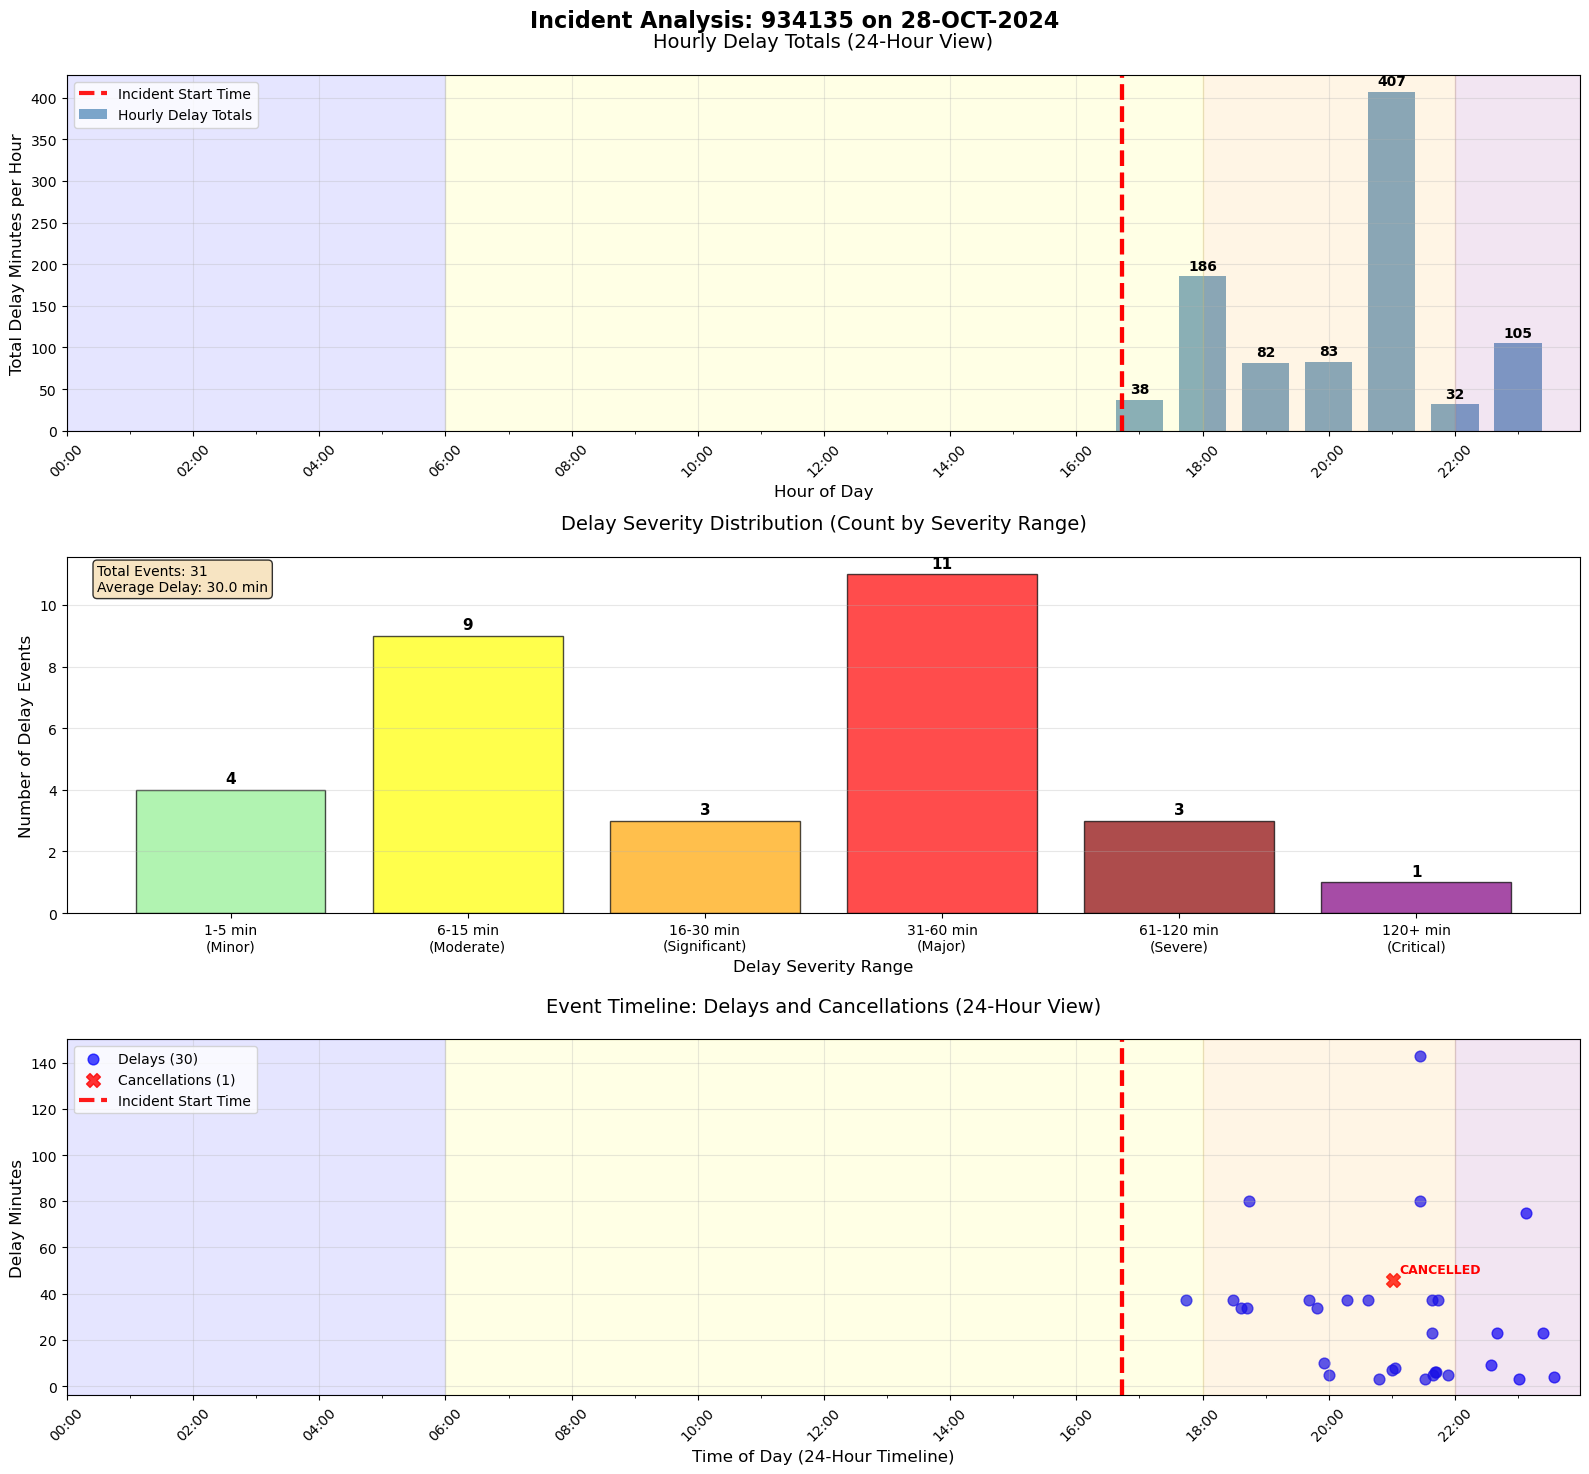


Summary:
  Total Delay Minutes: 931.5
  Total Cancellations: 1
  Total Records Found: 31
  Incident Number: 934135
  Date: 28-OCT-2024
  Time Range: 17:44 - 23:34
  Peak Delay Event: 143.0 minutes at 21:27 (Regular Delay)
  Peak Regular Delay: 143.0 minutes at 21:27
  Peak Cancellation Delay: 46.0 minutes at 21:01



In [67]:
# Test the enhanced function with visualizations
print("Testing Enhanced Aggregate View with Charts")
print("=" * 60)

# Test 1: Incident 934135 on 28-OCT-2024 (this had 31 records, good for visualization)
print("Test 1: Incident 934135 on 28-OCT-2024 (31 records)")
result1 = aggregate_view(934135, "28-OCT-2024")
print("\nSummary:")
if result1:
    for key, value in result1.items():
        print(f"  {key}: {value}")
print()

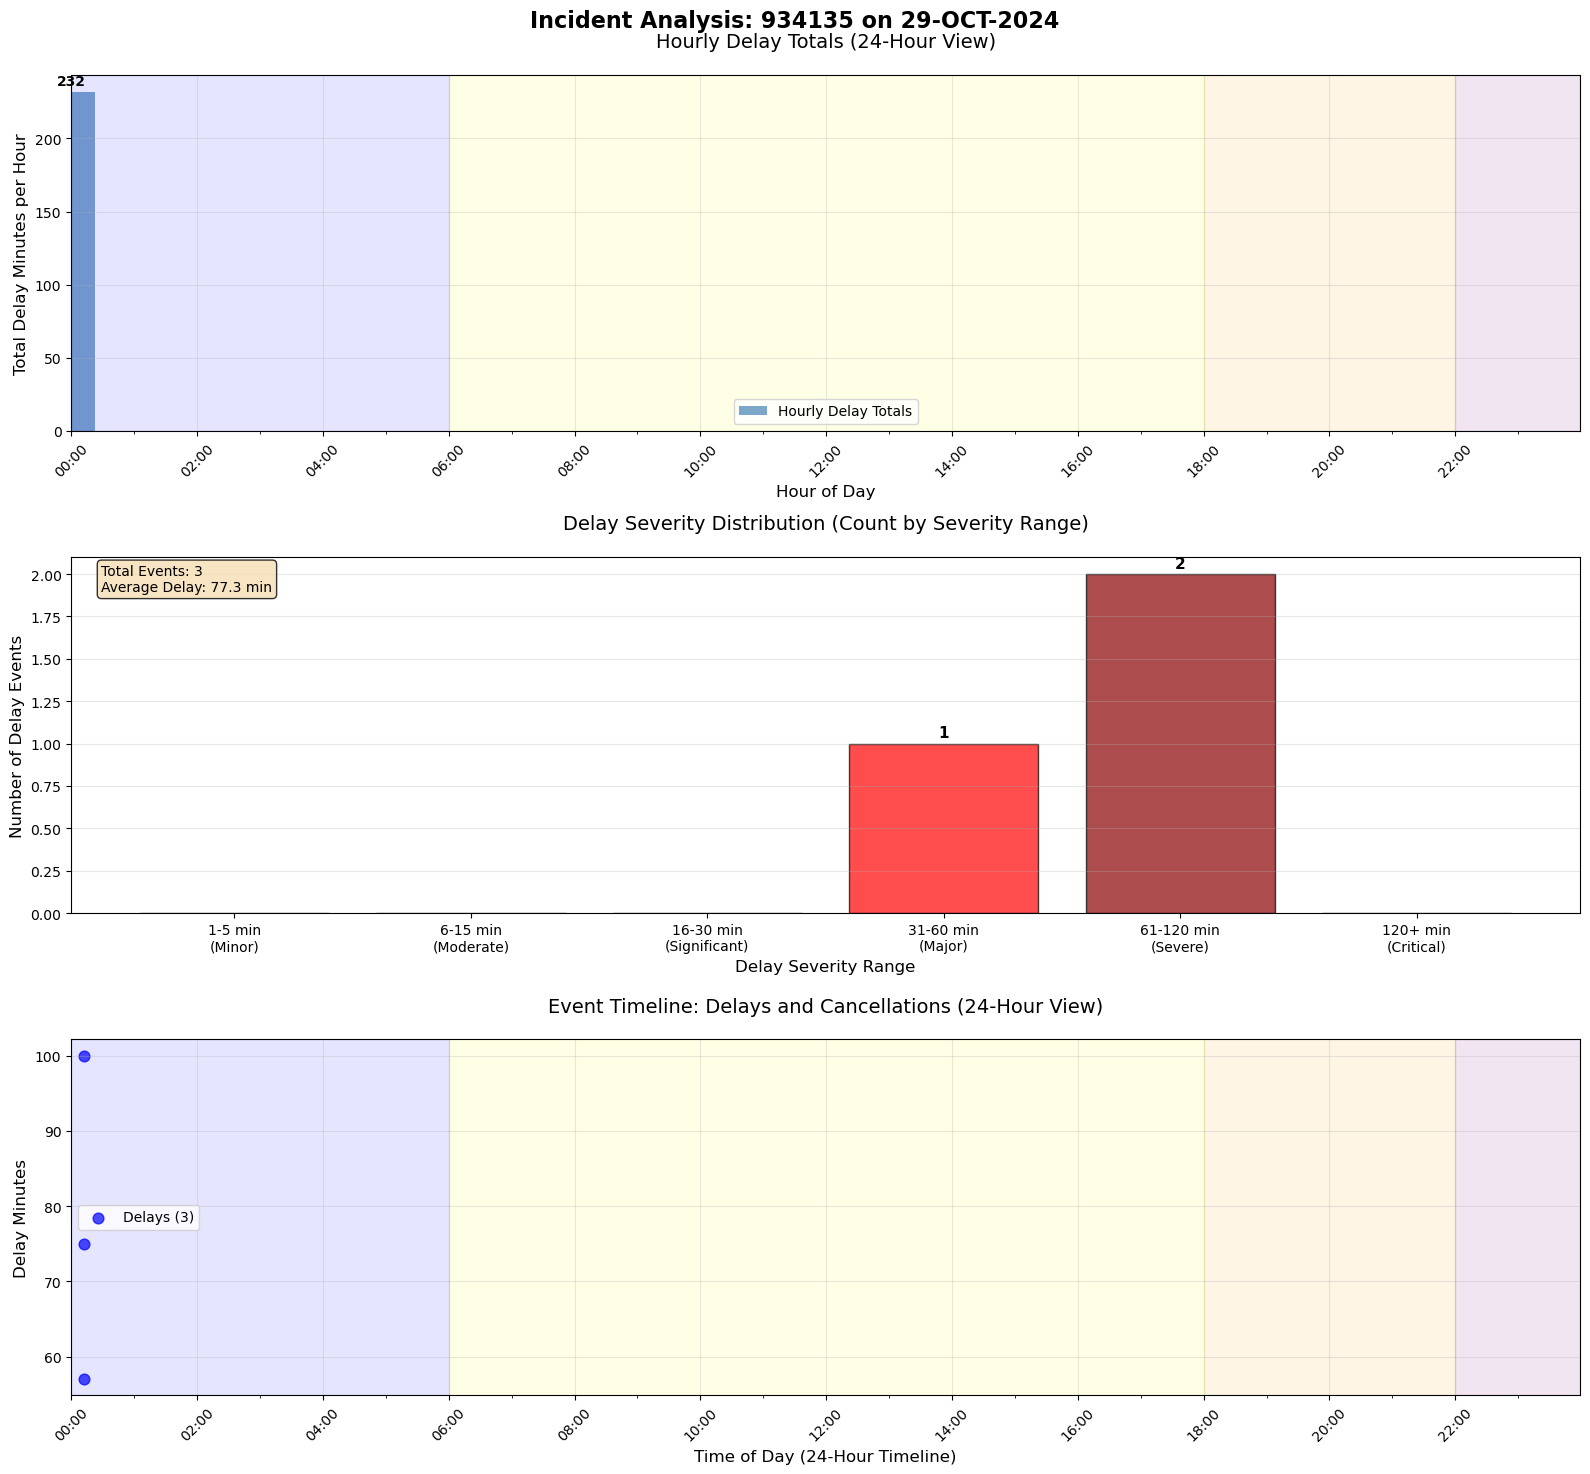


Summary:
  Total Delay Minutes: 232.0
  Total Cancellations: 0
  Total Records Found: 3
  Incident Number: 934135
  Date: 29-OCT-2024
  Time Range: 00:12 - 00:12
  Peak Delay Event: 100.0 minutes at 00:12



In [29]:
# Testing the next day for comparison
result2 = aggregate_view(934135, "29-OCT-2024")
print("\nSummary:")
if result2:
    for key, value in result2.items():
        print(f"  {key}: {value}")
print()

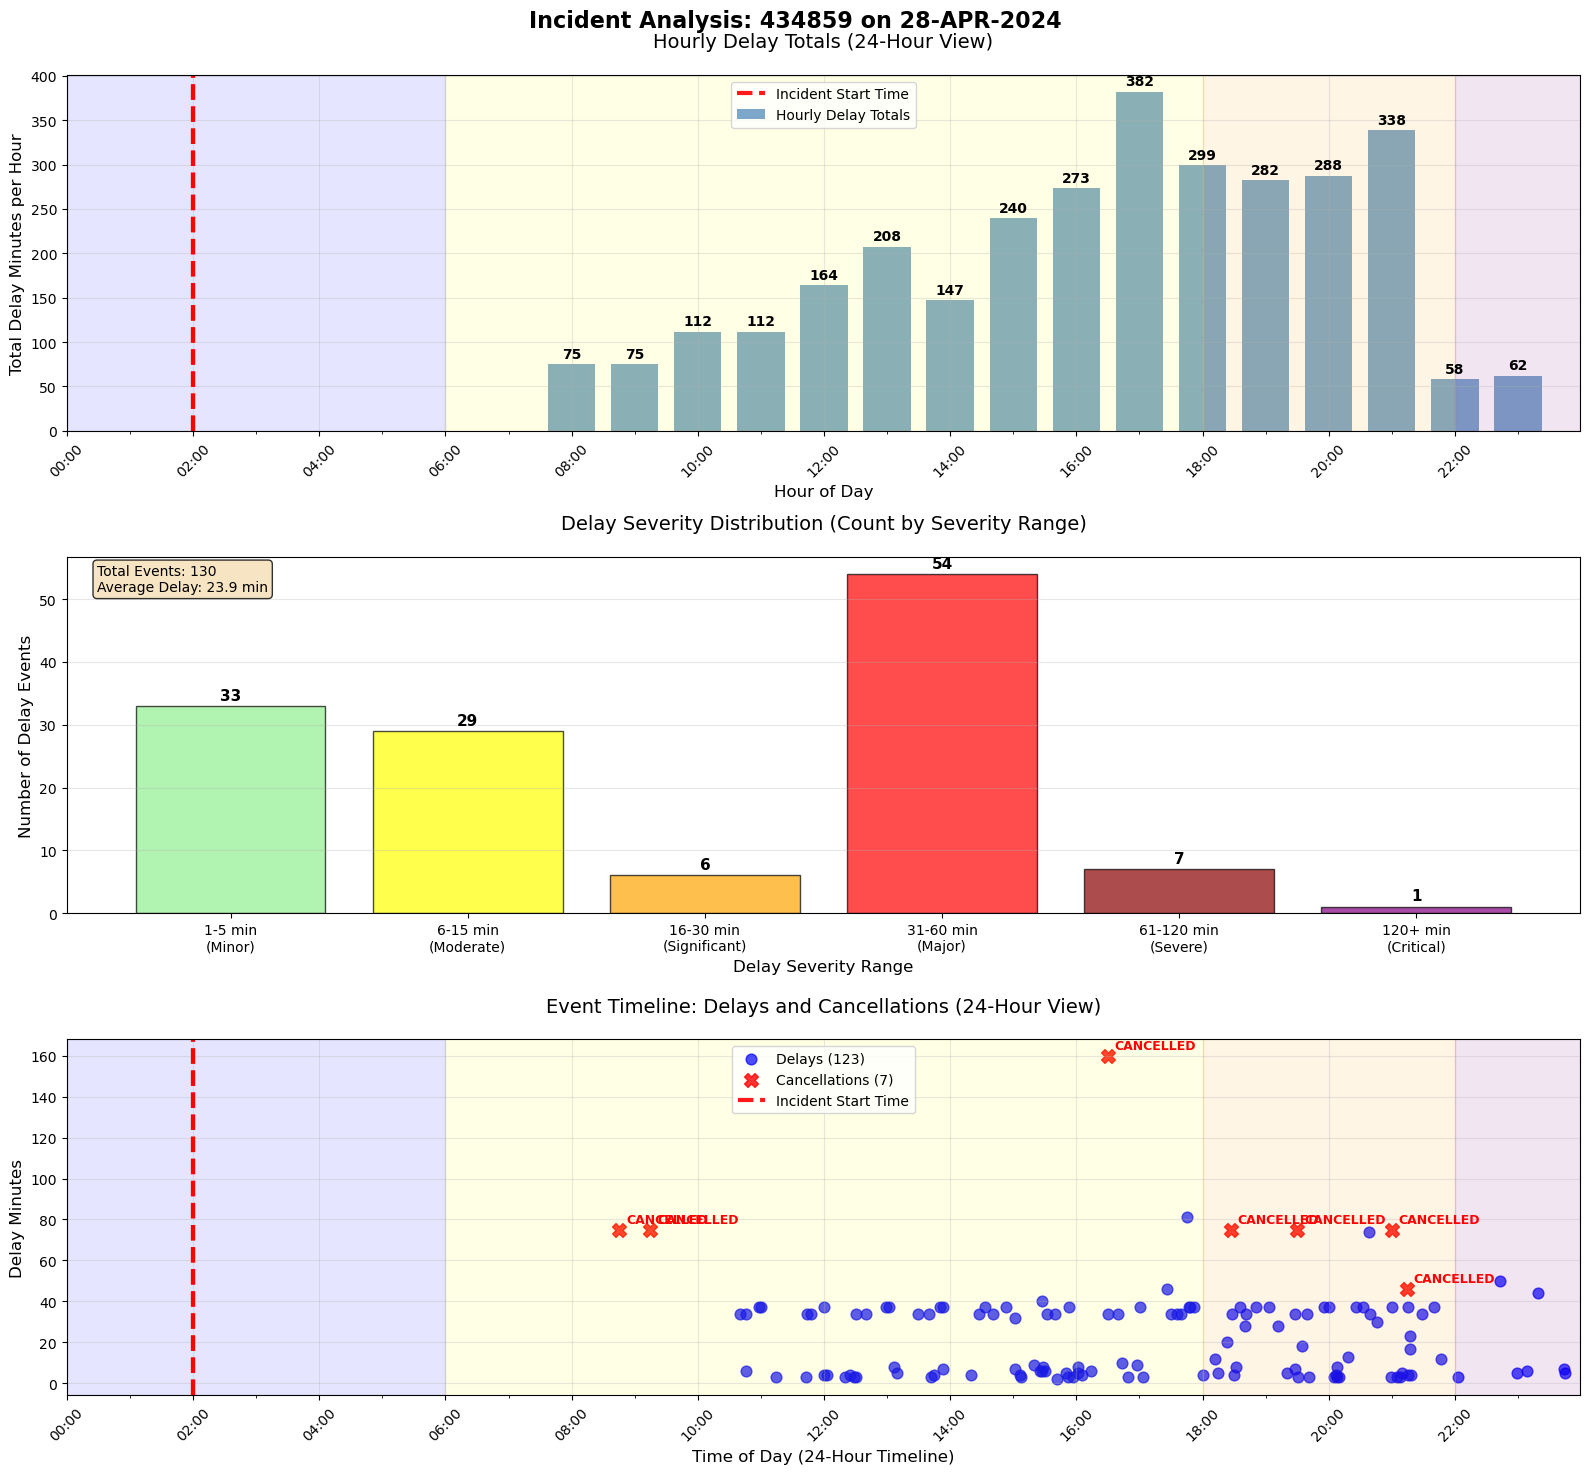


Summary:
  Total Delay Minutes: 3113.0
  Total Cancellations: 7
  Total Records Found: 130
  Incident Number: 434859
  Date: 28-APR-2024
  Time Range: 08:45 - 23:45
  Peak Delay Event: 160.0 minutes at 16:30 (CANCELLED SERVICE)
  Peak Regular Delay: 81.0 minutes at 17:45
  Peak Cancellation Delay: 160.0 minutes at 16:30



In [75]:
result6 = aggregate_view(434859, '28-APR-2024')
print("\nSummary:")
if result6:
    for key, value in result6.items():
        print(f"  {key}: {value}")
print()

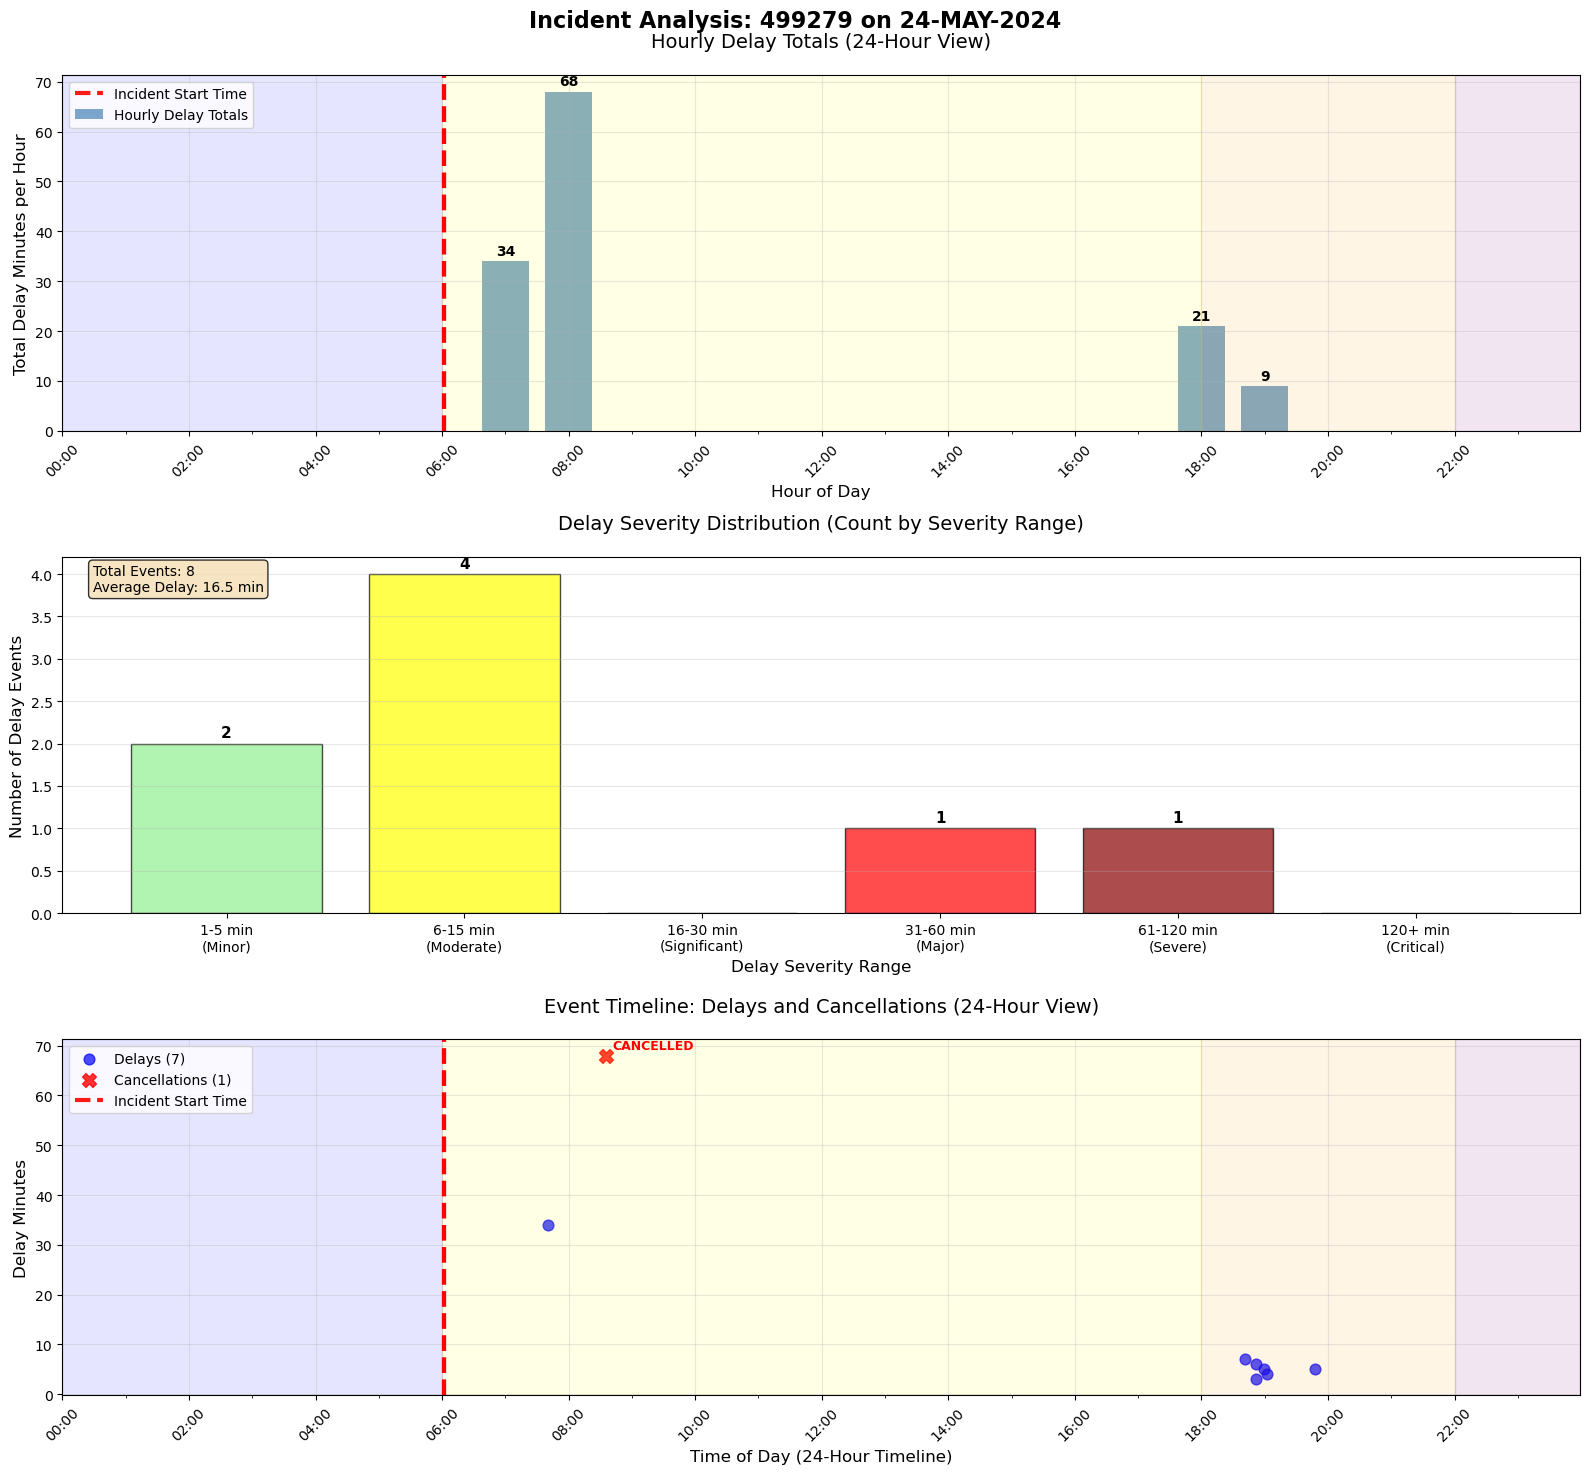


Summary:
  Total Delay Minutes: 132.0
  Total Cancellations: 1
  Total Records Found: 8
  Incident Number: 499279
  Date: 24-MAY-2024
  Time Range: 07:40 - 19:48
  Peak Delay Event: 68.0 minutes at 08:35 (CANCELLED SERVICE)
  Peak Regular Delay: 34.0 minutes at 07:40
  Peak Cancellation Delay: 68.0 minutes at 08:35



In [69]:
result5 = aggregate_view(499279, '24-MAY-2024')
print("\nSummary:")
if result5:
    for key, value in result5.items():
        print(f"  {key}: {value}")
print()

In [76]:
print(station_data.columns)

Index(['TRAIN_SERVICE_CODE', 'PLANNED_ORIGIN_LOCATION_CODE',
       'PLANNED_ORIGIN_GBTT_DATETIME', 'PLANNED_DEST_LOCATION_CODE',
       'PLANNED_DEST_GBTT_DATETIME', 'PLANNED_CALLS', 'ACTUAL_CALLS',
       'PFPI_MINUTES', 'INCIDENT_REASON', 'INCIDENT_NUMBER', 'EVENT_TYPE',
       'SECTION_CODE', 'DELAY_DAY', 'EVENT_DATETIME', 'ENGLISH_DAY_TYPE',
       'STATION_ROLE', 'DFT_CATEGORY', 'PLATFORM_COUNT', 'DATASET_TYPE',
       'WEEKDAY'],
      dtype='object')
